# Lorenz attractor predictions using Reservoir Computing based on **NVAR** (*nonlinear vector autoregression*)

*Reference:* "Next generation reservoir computing", Gauthier *et al.* (2021), https://www.nature.com/articles/s41467-021-25801-2

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from reservoirpy.datasets import lorenz
from reservoirpy.observables import nrmse
from reservoirpy.nodes import Ridge, NVAR

import time as time
import pandas as pd
from IPython.display import Image

### Implementation using *ReservoirPy*, a Python library (based on *NumPy* and *SciPy*) that allows to implement Reservoir Computing architectures

https://reservoirpy.readthedocs.io/en/latest/index.html

https://github.com/reservoirpy/reservoirpy

- As for the reservoir node of the RC architecture, we use the ReservoirPy's **NVAR** node, a Nonlinear Vector AutoRegressive machine implemented as described in *Reference*.

***

The state $\mathbb{O}_{total}$ of the NVAR first contains a serie of linear features $\mathbb{O}_{lin}$ made of input data concatenated with delayed inputs:

$$
\mathbb{O}_{lin}[t] = \mathbf{X}[t] \oplus \mathbf{X}[t - s] \oplus \mathbf{X}[t - 2s] \oplus \dots \oplus \mathbf{X}[t - (k-1)s]
$$

where $\mathbf{X}[t]$ are the inputs at time $t$, $k$ is the delay and $s$ is the strides (only one input every $s$ inputs within the delayed inputs is used). The operator $\oplus$ denotes the concatenation.

In addition to these linear features, nonlinear representations $\mathbb{O}_{nonlin}^n$ of the inputs are contructed using all unique monomials of order $n$ of these inputs:

$$
\mathbb{O}_{nonlin}^n[t] = \mathbb{O}_{lin}[t] \otimes \mathbb{O}_{lin}[t] \overbrace{\otimes \dots \otimes}^{n-1~\mathrm{times}} \mathbb{O}_{lin}[t]
$$

where $\otimes$ is the operator denoting an outer product followed by the selection of all unique monomials generated by this outer product. Under the hood, this product is computed by ReservoirPy by finding all unique combinations of input features and multiplying each combination of terms.

Finally, all representations are gathered to form the final feature vector $\mathbb{O}_{total}$:

$$
\mathbb{O}_{total} = \mathbb{O}_{lin}[t] \oplus \mathbb{O}_{nonlin}^n[t]
$$

***

- As for the offline readout node of the RC architecture, we use the ReservoirPy's **Ridge** node, a single layer of neurons whose readout weights are learned through Tikhonov linear regression using $\mathbb{O}_{total}$.

In [3]:
def Plot1D(X, titl1, titl2, titl3, start, pt_number, lw):
    xs, ys, zs = X[:,0], X[:,1], X[:,2]

    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (15, 15))

    ax1.plot(xs[start:start+pt_number], lw=lw)
    ax1.set_title(titl1)
    ax1.set_xlabel("time")
    ax1.set_ylabel("X Axis")

    ax2.plot(ys[start:start+pt_number], lw=lw)
    ax2.set_title(titl2)
    ax2.set_xlabel("time")
    ax2.set_ylabel("Y Axis")

    ax3.plot(zs[start:start+pt_number], lw=lw)
    ax3.set_title(titl3)
    ax3.set_xlabel("time")
    ax3.set_ylabel("Z axis")

    plt.show()

In [4]:
def Plot2D(X, titl1, titl2, titl3, start, pt_number, lw, N, color):
    xs, ys, zs = X[:,0], X[:,1], X[:,2]
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (15, 5))

    ax1.set_title(titl1)
    ax1.set_xlabel("X Axis")
    ax1.set_ylabel("Y Axis")

    ax2.set_title(titl2)
    ax2.set_xlabel("X Axis")
    ax2.set_ylabel("Z Axis")

    ax3.set_title(titl3)
    ax3.set_xlabel("Y Axis")
    ax3.set_ylabel("Z Axis")

    if color:
        cmap = plt.cm.magma#plt.cm.winter
        for i in range(N-1):
            ax1.plot(X[i:i+2, 0], X[i:i+2, 1], color=cmap(255*i//N), lw=lw)
            ax2.plot(X[i:i+2, 0], X[i:i+2, 2], color=cmap(255*i//N), lw=lw)
            ax3.plot(X[i:i+2, 1], X[i:i+2, 2], color=cmap(255*i//N), lw=lw)
    else:
        ax1.plot(xs[start:start+pt_number], ys[start:start+pt_number], lw=lw)
        ax2.plot(xs[start:start+pt_number], zs[start:start+pt_number], lw=lw)
        ax3.plot(ys[start:start+pt_number], zs[start:start+pt_number], lw=lw)

    plt.show()

In [5]:
def plot3D(X, title, pt_number, N, color, start, lw):
    xs, ys, zs = X[:,0], X[:,1], X[:,2]
    fig = plt.figure(figsize=(10, 10))
    ax  = fig.add_subplot(111, projection='3d')
    ax.set_title(title)
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    ax.grid(False)

    if color:
        cmap = plt.cm.magma#plt.cm.winter
        for i in range(N-1):
            ax.plot(X[i:i+2, 0], X[i:i+2, 1], X[i:i+2, 2], color=cmap(255*i//N), lw=1.0)
    else:
        ax.plot(xs[start:start+pt_number], ys[start:start+pt_number], zs[start:start+pt_number], lw=lw)

    plt.show()

## 0. Generate Lorenz attractor timeseries

$$
\begin{split}
\dot{x} &= \sigma(y-x)\\
\dot{y} &= x(\rho-z)-y\\
\dot{z} &= xy - \beta z
\end{split}
$$

In [6]:
def lorenz_inside(x, y, z, sigma, rho, beta):
    """
    Given:
    x, y, z: a point of interest in three dimensional space
    sigma, rho, beta: parameters defining the lorenz attractor
    Returns:
    x_dot, y_dot, z_dot: values of the lorenz attractor's partial
    derivatives at the point x, y, z
    """
    x_dot = sigma*(y - x)
    y_dot = rho*x - y - x*z
    z_dot = x*y - beta*z
    return x_dot, y_dot, z_dot

def lorenz_generation(steps, rho, sigma, beta, x0, h, method, select_f):
    t1 = time.time() #times the computation

    if select_f == 1:
        # Need one more for the initial values
        xs = np.empty(steps + 1)
        ys = np.empty(steps + 1)
        zs = np.empty(steps + 1)
        # Set initial values
        xs[0], ys[0], zs[0] = x0[0], x0[1], x0[2]
        # Step through "time", calculating the partial derivatives at the current point
        # and using them to estimate the next point
        for i in range(steps):
            x_dot, y_dot, z_dot = lorenz_inside(xs[i], ys[i], zs[i], sigma, rho, beta)
            xs[i + 1] = xs[i] + (x_dot * h)
            ys[i + 1] = ys[i] + (y_dot * h)
            zs[i + 1] = zs[i] + (z_dot * h)
        X = np.array([xs, ys, zs])
        t2 = time.time()
        return X.T, xs, ys, zs
        print ('computation took ',t2-t1,' seconds.')

    if (select_f == 2):# or (h > 0.01):
        X = lorenz(steps, rho=rho, sigma=sigma, beta=beta, x0=x0, h=h, method = method, atol = atol, rtol = rtol)
        xs, ys, zs = X[:,0], X[:,1], X[:,2]
        t2 = time.time()
        return X, xs, ys, zs
        #print ('computation took ',t2-t1,' seconds.')

In [7]:
dt         = 0.001 # time step duration (in time unit)
train_time = 20.   # training time (in time unit) # was 10.
test_time  = 200.  # testing time (idem) # was 185
warm_time  = 25.    # warmup time (idem): should always be > k * s # was 5

# discretization
train_steps = round(train_time / dt)
test_steps  = round(test_time  / dt)
warm_steps  = round(warm_time  / dt)

In [8]:
# Lorenz parameters
n_timesteps = train_steps + test_steps + warm_steps
rho    =  28
sigma  = 10
beta   = 8/3
x0     = [-8, 8, 27]
method = 'LSODA' # https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html
atol = np.ones(3) * 1e-12
rtol = 1e-12

X, xs, ys, zs = lorenz_generation(n_timesteps, rho, sigma, beta, x0=x0, h=dt, method=method, select_f=2)

lorenz_df = pd.DataFrame(X, columns=['x', 'y', 'z'])
lorenz_df

,x,y,z
0,-8.000000,8.000000,27.000000
1,-7.840879,7.983553,26.864883
2,-7.683508,7.966251,26.731519
3,-7.527880,7.948146,26.599891
4,-7.373985,7.929292,26.469981
...,...,...,...
244995,3.658175,6.461821,11.823847
244996,3.686335,6.514749,11.816153
244997,3.714743,6.568110,11.808860
244998,3.743403,6.621906,11.801972


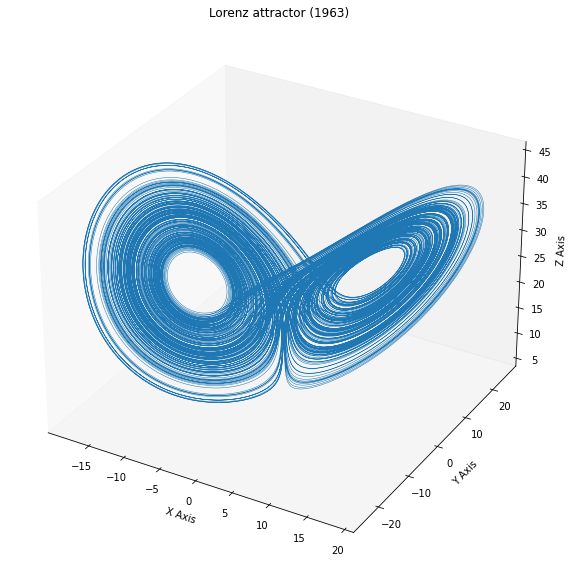

In [9]:
plot3D(X, title = "Lorenz attractor (1963)", start=0, pt_number = n_timesteps, N = n_timesteps, color=False, lw = 0.5)

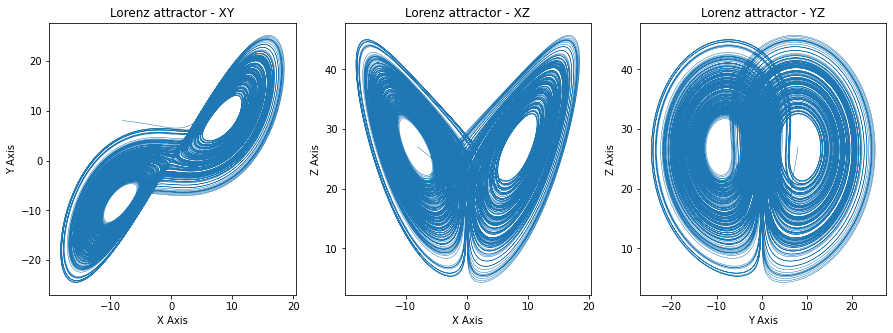

In [10]:
Plot2D(X, "Lorenz attractor - XY", "Lorenz attractor - XZ", "Lorenz attractor - YZ", start=0, pt_number=n_timesteps, lw=0.5, N = n_timesteps, color=False)

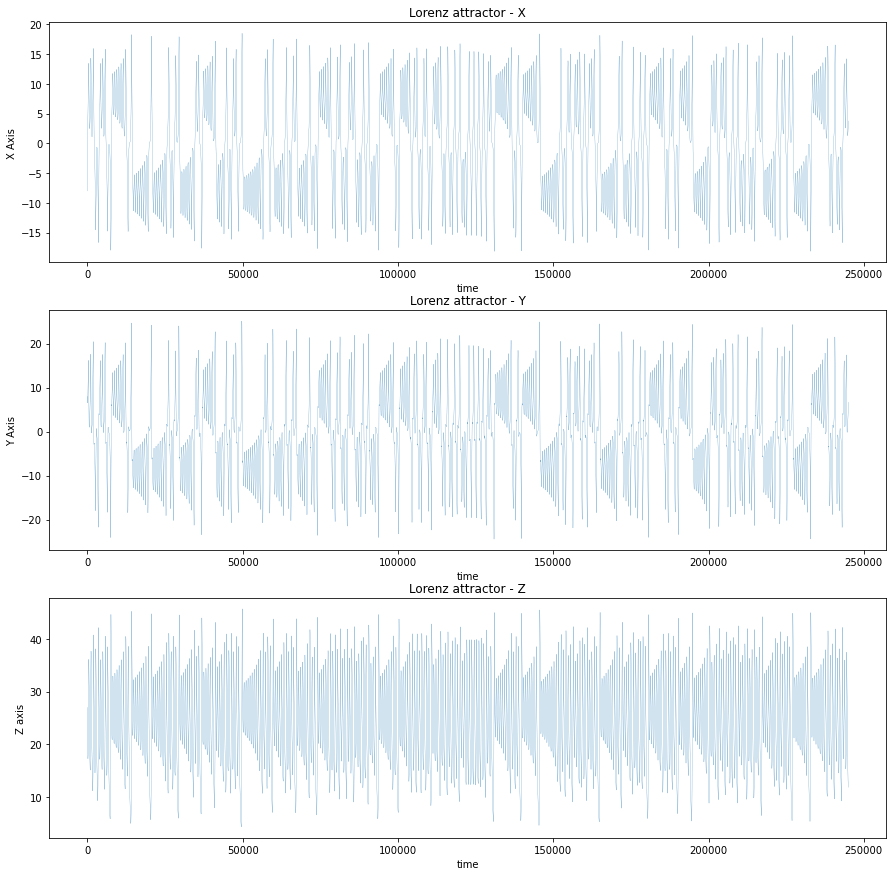

In [11]:
Plot1D(np.array([xs, ys, zs]).T, "Lorenz attractor - X", "Lorenz attractor - Y", "Lorenz attractor - Z", start=0, pt_number=n_timesteps, lw=0.2)

## 1. NVAR for 3D Lorenz attractor forecasting

Let's define an NVAR with:

- delay $k=2$
- strides $s=1$
- order $n=2$

Therefore, the final feature vector $\mathbb{O}_{total}$ will be the following:

$$
\mathbb{O}_{total}[t] = \mathbb{O}_{lin}[t] \oplus \mathbb{O}_{nonlin}[t]
$$

where

$$
\begin{align}
\mathbb{O}_{lin}[t] &=
    \begin{bmatrix}
         x_t\\y_t\\z_t\\x_{t-1}\\y_{t-1}\\z_{t-1}
    \end{bmatrix}
&
\mathbb{O}_{nonlin}[t] &=
    \begin{bmatrix}
       x_t^2\\x_t y_t\\x_t z_t\\x_t x_{t-1}\\x_t y_{t-1}\\x_t
       z_{t-1}\\y_t^2\\y_t z_t\\y_t x_{t-1}\\y_t y_{t-1}\\y_t z_{t-1}\\z_t^2\\z_t x_{t-1}\\z_t y_{t-1}\\z_t
       z_{t-1}\\x_{t-1}^2\\x_{t-1} y_{t-1}\\x_{t-1} z_{t-1}\\y_{t-1}^2\\y_{t-1} z_{t-1}\\z_{t-1}^2
    \end{bmatrix}
\end{align}
$$

Then, let's connect the NVAR to a readout layer with offline learning using Tikhonov linear regression (Ridge regularization).

In [ ]:
nvar = NVAR(delay=3, order=2, strides=5)
readout = Ridge(output_dim=3, ridge=2.5e-3)# ridge was 2.5e-6

model = nvar >> readout

https://github.com/reservoirpy/reservoirpy/tree/master/.github/workflowsNow, let's train the model to perform one-step-ahead prediction, i.e., to infer the value of $\mathbf{X}[t+1]$ knowing the value of $\mathbf{X}[t]$.

In [ ]:
X_train  = X[:train_steps+warm_steps-1]
Y_train  = X[1:train_steps+warm_steps]

model = model.fit(X_train, Y_train, warmup=warm_steps)

Let's visualize the coefficients learned by the model:

In [ ]:
lin = ["$x_t$", "$y_t$", "$z_t$", "$x_{t-1}$", "$y_{t-1}$", "$z_{t-1}$", "$x_{t-2}$", "$y_{t-2}$", "$z_{t-2}$"]

nonlin = []
for idx in nvar._monomial_idx:
    idx = idx.astype(int)
    if idx[0] == idx[1]:
        c = lin[idx[0]][:-1] + "^2$"
    else:
        c = " ".join((lin[idx[0]][:-1], lin[idx[1]][1:]))

    nonlin.append(c)

coefs = ["$c$"] + lin + nonlin

In [ ]:
fig = plt.figure(figsize=(10, 10))

Wout = np.r_[readout.bias, readout.Wout]
x_Wout, y_Wout, z_Wout = Wout[:, 0], Wout[:, 1], Wout[:, 2]

ax = fig.add_subplot(131)
ax.set_xlim(-0.2, 0.2)
ax.grid(axis="y")
ax.set_xlabel("$[W_{out}]_x$")
ax.set_ylabel("Features")
ax.set_yticks(np.arange(len(coefs)))
ax.set_yticklabels(coefs[::-1])
ax.barh(np.arange(x_Wout.size), x_Wout.ravel()[::-1])

ax1 = fig.add_subplot(132)
ax1.set_xlim(-0.2, 0.2)
ax1.grid(axis="y")
ax1.set_yticks(np.arange(len(coefs)))
ax1.set_xlabel("$[W_{out}]_y$")
ax1.barh(np.arange(y_Wout.size), y_Wout.ravel()[::-1])

ax2 = fig.add_subplot(133)
ax2.set_xlim(-0.2, 0.2)
ax2.grid(axis="y")
ax2.set_yticks(np.arange(len(coefs)))
ax2.set_xlabel("$[W_{out}]_z$")
ax2.barh(np.arange(z_Wout.size), z_Wout.ravel()[::-1])

plt.show()

Now, let's perform one-step-ahead prediction:

In [ ]:
nvar.run(X[train_steps:warm_steps+train_steps]) # warming phase

u = X[warm_steps+train_steps]
Y_pred = np.zeros((test_steps, readout.output_dim))
for i in range(test_steps):
    Y_pred[i, :] = model(u)
    u = Y_pred[i, :]

In [ ]:
Y_test = X[warm_steps+train_steps:]

fig = plt.figure(figsize=(20, 10))
ax  = fig.add_subplot(121, projection='3d')
ax.set_title("Generated attractor")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$z$")
ax.grid(False)
ax.plot(Y_pred[:, 0], Y_pred[:, 1], Y_pred[:, 2], color='red', lw=.3)

ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title("Real attractor")
ax2.grid(False)
ax2.plot(Y_test[:, 0], Y_test[:, 1], Y_test[:, 2], lw=.3)

plt.show()

## 2. Lobe prediction

### 2.1 Definition of reconstructing functions

In [23]:
def general_reconstruction(X, train_steps, warm_steps, n_leaps, leap_len, delay, order, strides, ridge, verb):
    
    shift = n_leaps*leap_len
    nvar    = NVAR(delay=delay, order=order, strides=strides)
    readout = Ridge(output_dim=1, ridge=ridge)
    model = nvar >> readout
    
    X_train = X[:train_steps+warm_steps-leap_len, 0]
    X_train = X_train.reshape(-1,1) # x coordinate
    Y_train = X[leap_len:train_steps+warm_steps, 0].reshape(-1,1)  # z coordinate
    model = model.fit(X_train, Y_train, warmup=warm_steps)
    nvar.run(X[train_steps:warm_steps+train_steps, 0].reshape(-1,1)) # warming phase
    
    X_test = X[warm_steps+train_steps:-shift, 0]
    X_test = X_test.reshape(-1,1) # x coordinate
    Y_test = X[warm_steps+train_steps+shift:, 0].reshape(-1,1)
    iterative_prediction = X_test
    
    for i in range(n_leaps):
        iterative_prediction = model.run(iterative_prediction)
        if verb:
            print(str(i+1)+"th/"+str(n_leaps)+" prediction step performed")
    Y_pred = iterative_prediction
    
    Y_differences = np.abs(Y_pred-Y_test)
    
    return(Y_pred, Y_test, Y_differences, shift, readout)


def smoother(sign_vec, window, tolerance):
    
    new_sign_vec = sign_vec.copy()
    
    for i in range(window, len(sign_vec)-window):
        if np.count_nonzero(sign_vec[i-window:i+window]*sign_vec[i] < 0) > 2*tolerance*window:
            new_sign_vec[i] = - sign_vec[i]
            
    return(new_sign_vec)


def analizer(triggers_real, triggers_pred_smoothed, ranger):
    
    triggers_wrong = triggers_pred_smoothed.copy()
    
    for i in range(ranger, len(triggers_real)-ranger):
        if triggers_real[i] > 0.5:
            if np.count_nonzero(triggers_pred_smoothed[i-ranger: i+ranger] > 0.5) > 0.5:
                triggers_wrong[i-ranger: i+ranger] = 0 * triggers_real[i-ranger: i+ranger]
            else:
                triggers_wrong[i-ranger: i+ranger] = -1 * triggers_real[i-ranger: i+ranger]
                #print(i)
                
    return(triggers_wrong)


def grouper(triggers_wrong, groupsize):
    
    triggers_wrong_grouped = triggers_wrong.copy()
    state = 0
    
    for i in range(groupsize, len(triggers_wrong)-groupsize):
        if state == 1 and np.count_nonzero(triggers_wrong[i-groupsize:i+groupsize] > 0.5) > 1:
            triggers_wrong_grouped[i-groupsize:i+groupsize] = 0 * triggers_wrong[i-groupsize:i+groupsize]
            triggers_wrong_grouped[i] = 1
            state = 0
        if np.count_nonzero(triggers_wrong[i-groupsize:i+groupsize] > 0.5) < 1:
            state = 1
            
    return(triggers_wrong_grouped)


def accuracy_detector(Y_pred, Y_test, window, tolerance, ranger, groupsize):
    
    Y_test_sign = np.sign(Y_test)
    Y_pred_sign = np.sign(Y_pred)
    Y_differences_sign = np.abs(Y_pred_sign-Y_test_sign)/2
    Y_pred_sign_smoothed = smoother(Y_pred_sign, window, tolerance)
    Y_differences_sign_smoothed = np.abs(Y_pred_sign_smoothed-Y_test_sign)/2
    
    error_level = np.sum(Y_differences_sign)/len(Y_differences_sign)
    error_level_smoothed = np.sum(Y_differences_sign_smoothed)/len(Y_differences_sign_smoothed)

    triggers_real = np.abs(Y_test_sign[1:]-Y_test_sign[:-1])/2
    #print(triggers_real)
    #triggers_pred = np.abs(Y_pred_sign[1:]-Y_pred_sign[:-1])
    triggers_pred_smoothed = np.abs(Y_pred_sign_smoothed[1:]-Y_pred_sign_smoothed[:-1])/2
    
    triggers_wrong = analizer(triggers_real, triggers_pred_smoothed, ranger)
    triggers_wrong = grouper(triggers_wrong, groupsize)
    
    true_positive = np.count_nonzero(triggers_real > 0.5)
    false_positive = np.count_nonzero(triggers_wrong > 0.5)
    false_negative = np.count_nonzero(triggers_wrong < -0.5)
    total_triggers = true_positive + false_positive
    
    true_positive_rate = true_positive/total_triggers
    false_positive_rate = false_positive/total_triggers
    false_negative_rate = false_negative/total_triggers
    
    return(Y_test_sign, Y_pred_sign, Y_differences_sign,
           Y_pred_sign_smoothed, Y_differences_sign_smoothed,
           triggers_real, triggers_pred_smoothed, triggers_wrong,
           true_positive_rate, false_positive_rate, false_negative_rate)


def general_comparer(Y_pred, Y_test, Y_differences, first, last):
    
    fig, ax1 = plt.subplots(figsize=(24, 8))
    ax1.plot(Y_pred[first:last], label="Inferred", lw = 1)
    ax1.plot(Y_test[first:last], label="Truth", lw = 2, linestyle="--")
    ax1.plot(Y_differences[first:last], label="Absolute deviation", lw = 1, linestyle="-.")
    ax1.set_ylabel("x")
    ax1.set_xlabel("time")
    ax1.set_title("Lorenz attractor x component inferred value")
    plt.legend()
    plt.show()

## 2.2 Coordinate reconstruction and lobe detection

In [16]:
(Y_pred, Y_test, Y_differences, shift, readout) = general_reconstruction(X = X, train_steps = train_steps, warm_steps = warm_steps, n_leaps = 1, leap_len = 250, delay = 20, 
                                                                         order = 2, strides = 20, ridge = 1e-2, verb = True)

Running Model-0:   0%|                                    | 0/1 [00:00<?, ?it/s]
Running Model-0: 253it [00:00, 2523.86it/s]                                     
Running Model-0: 515it [00:00, 2579.89it/s]
Running Model-0: 773it [00:00, 2447.21it/s]
Running Model-0: 1075it [00:00, 2664.62it/s]
Running Model-0: 1378it [00:00, 2791.72it/s]
Running Model-0: 1659it [00:00, 2709.67it/s]
Running Model-0: 1931it [00:00, 2525.88it/s]
Running Model-0: 2222it [00:00, 2639.13it/s]
Running Model-0: 2489it [00:00, 2616.27it/s]
Running Model-0: 2757it [00:01, 2632.86it/s]
Running Model-0: 3025it [00:01, 2645.46it/s]
Running Model-0: 3324it [00:01, 2745.74it/s]
Running Model-0: 3614it [00:01, 2790.48it/s]
Running Model-0: 3894it [00:01, 2668.77it/s]
Running Model-0: 4163it [00:01, 2651.94it/s]
Running Model-0: 4452it [00:01, 2719.88it/s]
Running Model-0: 4725it [00:01, 2656.43it/s]
Running Model-0: 5011it [00:01, 2714.64it/s]
Running Model-0: 5290it [00:01, 2736.11it/s]
Running Model-0: 5565it [00:02

Fitting node Ridge-0...


Running NVAR-0: 100%|███████████████████| 25000/25000 [00:04<00:00, 6225.17it/s]
Running Model-0: 199750it [00:49, 4007.83it/s]                                  

1th/1 prediction step performed


In [48]:
(Y_test_sign, Y_pred_sign, Y_differences_sign,
           Y_pred_sign_smoothed, Y_differences_sign_smoothed,
           triggers_real, triggers_pred_smoothed, triggers_wrong,
           true_positive_rate, false_positive_rate, false_negative_rate
          ) = accuracy_detector(Y_pred = Y_pred, Y_test = Y_test, window = 300, tolerance = 0.51, ranger = 100, groupsize = 300)

In [49]:
print(true_positive_rate, false_positive_rate, false_negative_rate)

0.7664233576642335 0.23357664233576642 0.23357664233576642


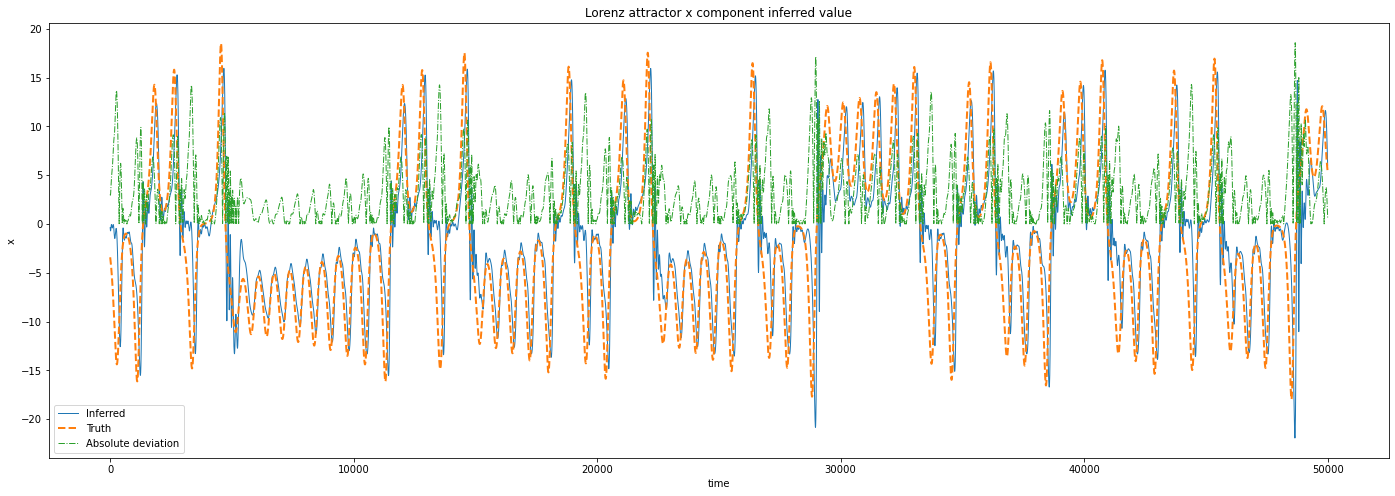

In [50]:
general_comparer(Y_pred, Y_test, Y_differences, first = 0, last = 50000)

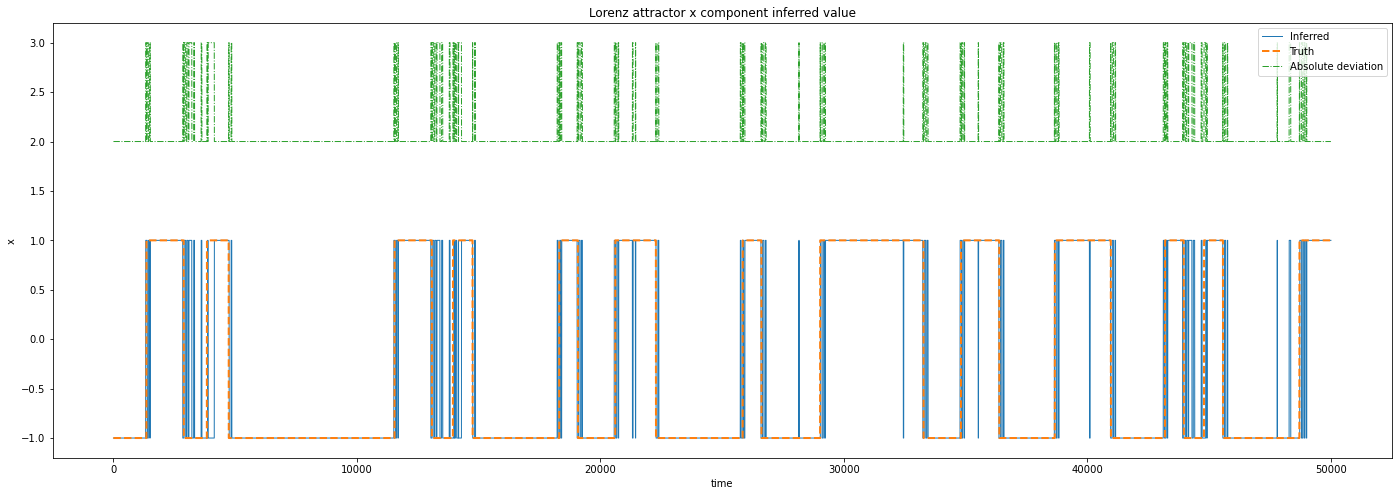

In [51]:
general_comparer(Y_test = Y_test_sign, Y_pred = Y_pred_sign, Y_differences = Y_differences_sign + 2, first = 0, last = 50000)

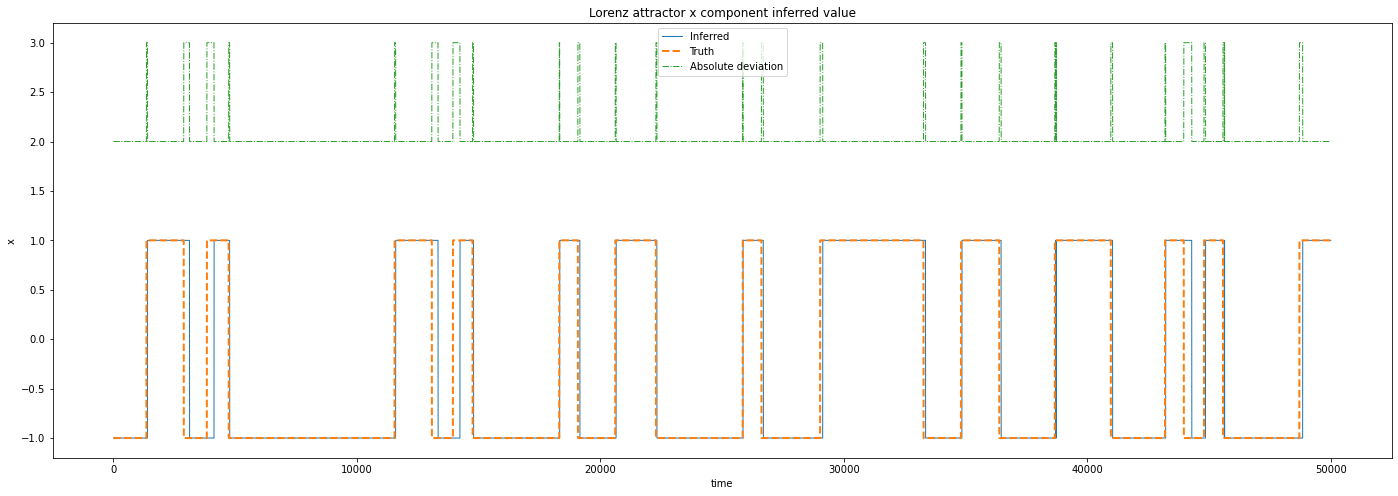

In [52]:
general_comparer(Y_test = Y_test_sign, Y_pred = Y_pred_sign_smoothed, Y_differences = Y_differences_sign_smoothed + 2, first = 0, last = 50000)

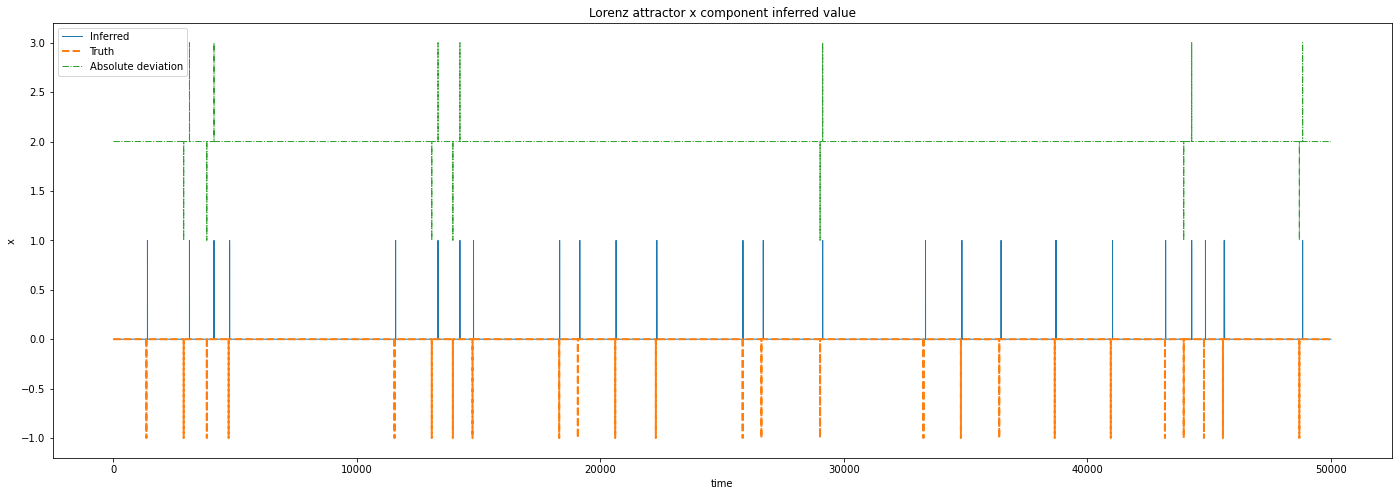

In [53]:
general_comparer(Y_test = -triggers_real, Y_pred = triggers_pred_smoothed, Y_differences = triggers_wrong + 2, first = 0, last = 50000)